### Importing library

In [101]:
import pandas as pd
import matplotlib.pyplot as plt

In [102]:
df = pd.read_csv('sample_sales_data3.csv')
print(df.shape)
df.head(2)

(100000, 16)


,ID,Job Title,Full Name,Gender,Age,Origin Country,Current Country,Search Engine From,Account Created,Product Name,Color,Size,Quantity,Unit Cost,Sales Price,Order Date
0,1,Clerk,Maya Emerson,F,32,Liberia,Niger,DuckDuckGo,2018-06-18 15:38:49Z,EMEL Fashion,Auburn,One Size,4,$11.94,$25.14,2020-09-21 19:08:01Z
1,2,Physician,Kurt Uddin,M,37,Iran,Gabon,Baidu,2019-04-18 18:24:54Z,Rip Curl,Brown,L,2,$11.33,$20.97,2021-08-12 03:51:39Z


### Calculating profit

Most entries have tailing white spaces

In [103]:
df = df.applymap(lambda x: str(x).strip())

Strip dollar sign and convert the values to float

In [104]:
df['CP'] = df[' Unit Cost '].apply(lambda x: x.lstrip('$')).astype(float)
df['SP'] = df[' Sales Price '].apply(lambda x: x.lstrip('$')).astype(float)

df['Quantity'] = df['Quantity'].astype(int)

In [105]:
df['Profit'] = (df['SP'] - df['CP']) * df['Quantity']
df.head(2)

,ID,Job Title,Full Name,Gender,Age,Origin Country,Current Country,Search Engine From,Account Created,Product Name,Color,Size,Quantity,Unit Cost,Sales Price,Order Date,CP,SP,Profit
0,1,Clerk,Maya Emerson,F,32,Liberia,Niger,DuckDuckGo,2018-06-18 15:38:49Z,EMEL Fashion,Auburn,One Size,4,$11.94,$25.14,2020-09-21 19:08:01Z,11.94,25.14,52.80
1,2,Physician,Kurt Uddin,M,37,Iran,Gabon,Baidu,2019-04-18 18:24:54Z,Rip Curl,Brown,L,2,$11.33,$20.97,2021-08-12 03:51:39Z,11.33,20.97,19.28


### Resampling the data

predicting to monthly sales

In [106]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Order Date'] = df['Order Date'].dt.tz_localize(None)

df.set_index('Order Date', inplace=True)

In [107]:
df = df.resample('M').sum()

In [108]:
df.isna().sum()

Quantity    0
CP          0
SP          0
Profit      0
dtype: int64

This dataset being forged, obviously contains no missing values<br>
If this code is to be deployed into production, we should perform a nan-value check, and fill any occurance with a rolling mean, with a window of 7day or a month.

### Checking for stationarity

In [110]:
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(df["Profit"])

print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print(f'No. of lags used: {adf_result[2]}')
print(f'No. of observations used : {adf_result[3]}')

ADF Statistic: -2.6207866816151117
p-value: 0.08877673394864649
No. of lags used: 9
No. of observations used : 15


Our data is NOT stationary
This should be nested in a check that doesn't involve manual inspection

In [114]:
import statsmodels.api as sm
from pylab import rcParams
rcParams["figure.figsize"] = (15,8)

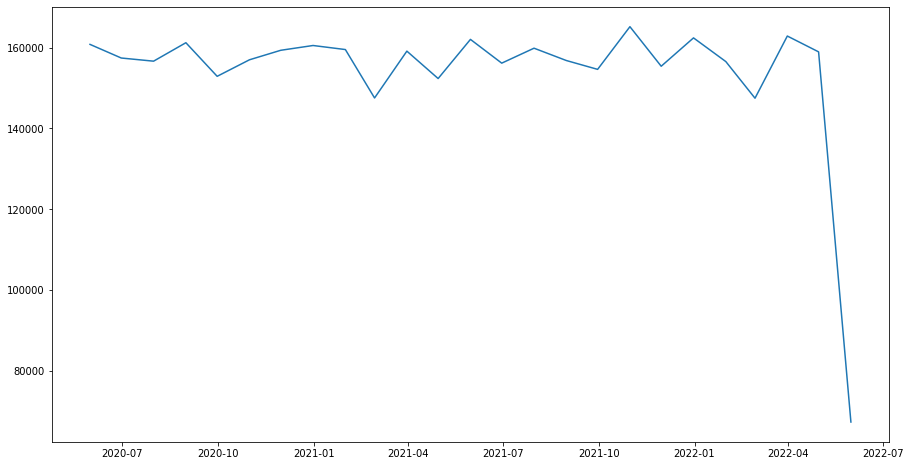

In [126]:
plt.plot(df['Order Date'], df['Profit'])
plt.show()

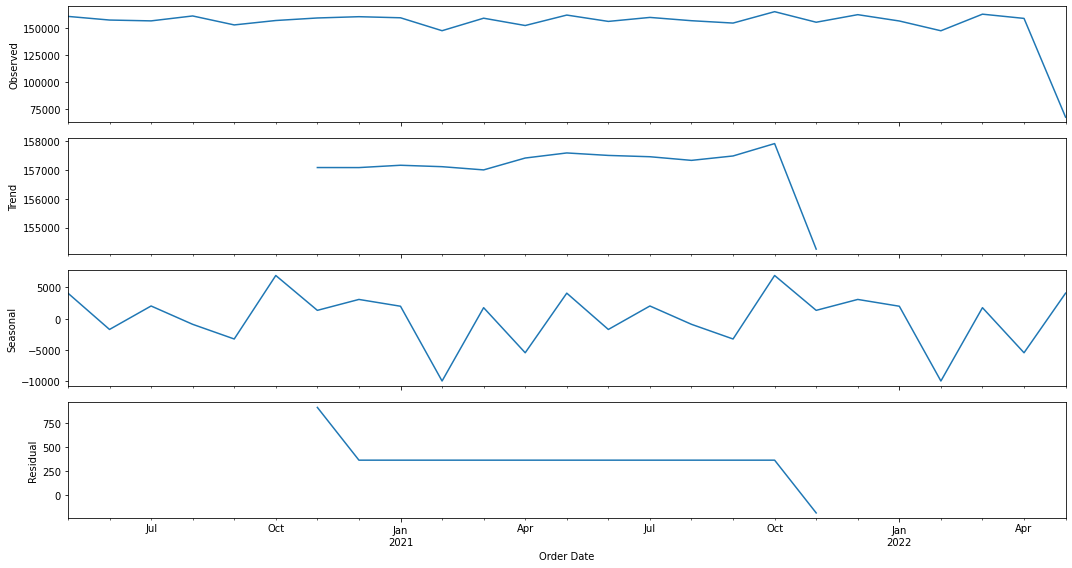

In [113]:
decompose_series = sm.tsa.seasonal_decompose(df[ 'Profit' ], model= 'additive' )
decompose_series.plot()
plt.show()

### Forcasting

In [115]:
df.reset_index(inplace=True)

In [116]:
df_univar = df[["Order Date", "Profit"]].rename(columns={"Order Date":"ds", "Profit":"y"})
df_univar.head()

,ds,y
0,2020-05-31,160805.95
1,2020-06-30,157432.47
2,2020-07-31,156651.02
3,2020-08-31,161217.99
4,2020-09-30,152902.32


In [84]:
from fbprophet import Prophet

In [117]:
# 70-30 Train-Test split
train_size = int(df_univar.shape[0] * 0.7)

df_train = df_univar.iloc[:train_size]
df_test = df_univar.iloc[train_size:]


assert df_univar.shape[0] == df_train.shape[0] + df_test.shape[0]

In [118]:
model = Prophet()
model.fit(df_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


In [123]:
# Prediction for the next months
periods_to_predict = df_test.shape[0]
future_dates = model.make_future_dataframe(periods=periods_to_predict, freq='M')

assert df_univar.shape[0] == future_dates.shape[0]

forecast = model.predict(future_dates)

<function matplotlib.pyplot.show>

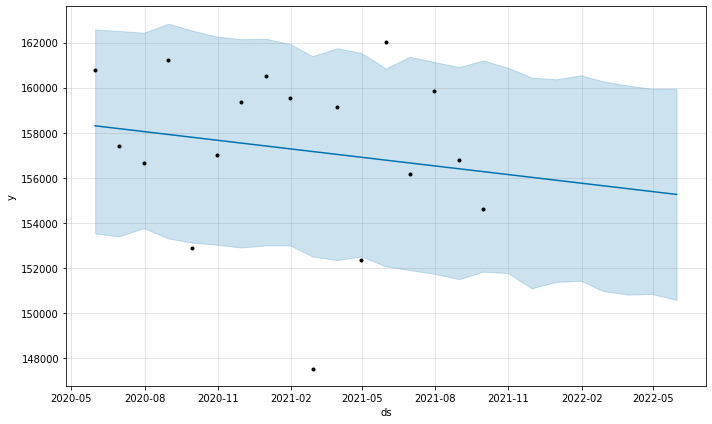

In [124]:
model.plot(forecast)
plt.show

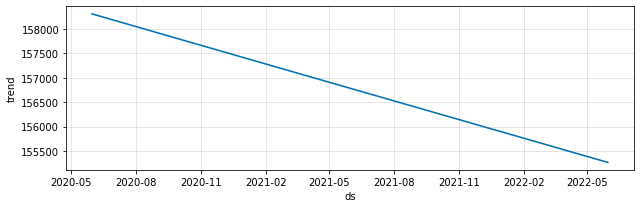

In [130]:
model.plot_components(forecast)
plt.show()

### Model Evaluation

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

y_pred = forecast[["yhat"]].iloc[train_size:]
y_test = df_test["y"]

In [ ]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAPE {round(MAPE, 2)}')